## 任务要求
- 利用已有数据建模，对新论文进行类别分类，使用论文标题完成类别分类


提供的分类思路：

- **思路1**：TF-IDF+机器学习分类器

    直接使用TF-IDF对文本提取特征，使用分类器进行分类，分类器的选择上可以使用SVM、LR、XGboost等

- **思路2**：FastText

    FastText是入门款的词向量，利用Facebook提供的FastText工具，可以快速构建分类器

- **思路3**：WordVec+深度学习分类器

    WordVec是进阶款的词向量，并通过构建深度学习分类完成分类。深度学习分类的网络结构可以选择TextCNN、TextRnn或者BiLSTM。

- **思路4**：Bert词向量

    Bert是高配款的词向量，具有强大的建模学习能力。

**注**：示例代码仅提供思路1、2的实现

## 导入库、配置环境和读入数据

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False	
plt.rcParams['font.sans-serif'] = 'SimHei'
# 因为我的环境下背景为黑色，黑色字体看不清，这里换了下颜色
plt.rcParams["xtick.color"] = 'orange'
plt.rcParams["ytick.color"] = 'orange'
plt.rcParams["text.color"] = 'orange'

In [2]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

In [3]:
data = readArxivFile('../arxiv-metadata-oai-snapshot.json', ['id', 'title', 'categories', 'abstract'], 200000)

In [65]:
# 实现classification_report的可视化
# 来源：https://blog.csdn.net/tigerxuchuanli/article/details/79320669?utm_medium=distribute.pc_relevant.
#       none-task-blog-BlogCommendFromMachineLearnPai2-1.control&depth_1-utm_source=distribute.pc_relevant.
#       none-task-blog-BlogCommendFromMachineLearnPai2-1.control
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''
 
    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)
 
    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
 
    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)
 
    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      
 
    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )
 
    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
 
    # Add color bar
    plt.colorbar(c)
 
    # Add text in each cell 
    show_values(c)
 
    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       
 
    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    global zip
    import  itertools
    zip = getattr(itertools, 'izip', zip)
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in  zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
 
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x.replace('avg','')) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
#         print(v)
        plotMat.append(v)
 
#     print('plotMat: {0}'.format(plotMat))
#     print('support: {0}'.format(support))
    
    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
#     return (classes,support,class_names)

## 代码实现
相关笔记可见[笔记](https://github.com/chenjiyan2001/Datawhale-2021.1-team-learning-AcademicTrends/tree/main/%E7%AC%94%E8%AE%B0)文件夹

### 数据预处理

#### 拼接标题和摘要，一起分类。

In [4]:
data['text'] = data['title'] + data['abstract']

data['text'] = data['text'].apply(lambda x: x.replace('\n',' '))
data['text'] = data['text'].apply(lambda x: x.lower())
data = data.drop(['abstract', 'title'], axis=1)

#### 对类别进行处理

In [5]:
# 包含母分类和子分类
data['categories_lst'] = data['categories'].apply(lambda categories : categories.split(' '))

# 只包含母分类
data['categories_onlymother'] = data['categories_lst'].apply(lambda categories : [category.split('.')[0] for category in categories])

In [107]:
data.head()

,id,categories,text,categories_lst,categories_onlymother
0,0704.0001,hep-ph,calculation of prompt diphoton production cros...,[hep-ph],[hep-ph]
1,0704.0002,math.CO cs.CG,sparsity-certifying graph decompositions we d...,"[math.CO, cs.CG]","[math, cs]"
2,0704.0003,physics.gen-ph,the evolution of the earth-moon system based o...,[physics.gen-ph],[physics]
3,0704.0004,math.CO,a determinant of stirling cycle numbers counts...,[math.CO],[math]
4,0704.0005,math.CA math.FA,from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...,"[math.CA, math.FA]","[math, math]"


#### 安装类别进行编码

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
data_label = mlb.fit_transform(data['categories_onlymother'])

In [9]:
data_label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

### 思路1 
TF-IDF+机器学习分类器

#### ① 使用CountVectorizer提取特征

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=4000)
cv_fit = cv.fit_transform(data['text'])

#### ② 使用TF-IDF提取特征

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(max_features=4000, use_idf=True, smooth_idf=True, stop_words='english') # 限制最多4000个单词
tv_fit = vectorizer.fit_transform(data['text'])

#### 构建多标签分类模型

##### ① CountVectorizer

In [110]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(cv_fit, data_label,test_size = 0.2,random_state = 1)

In [111]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
clf_1 = MultiOutputClassifier(MultinomialNB()).fit(x_train, y_train)

##### ② TF-IDF

In [115]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tv_fit, data_label,test_size = 0.2,random_state = 1)

In [116]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
clf_2 = MultiOutputClassifier(MultinomialNB()).fit(x_train, y_train)

#### 使用训练后的模型进行分类
这里的x_test等是有共用问题的，懒得修改变量名了，其实运行顺序是跑完一个模型就进行一次测试，再跑下一个

D:\Anaconda3 5.3.1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


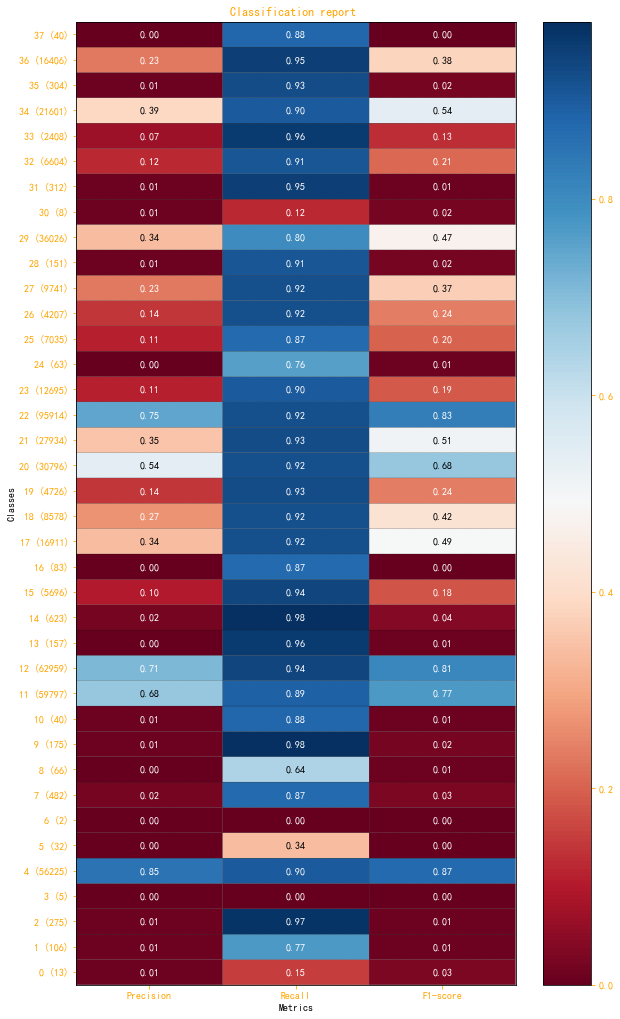

In [112]:
# 词频
from sklearn.metrics import classification_report
plot_classification_report(classification_report(y_test, clf_1.predict(x_test)))

D:\Anaconda3 5.3.1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3 5.3.1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


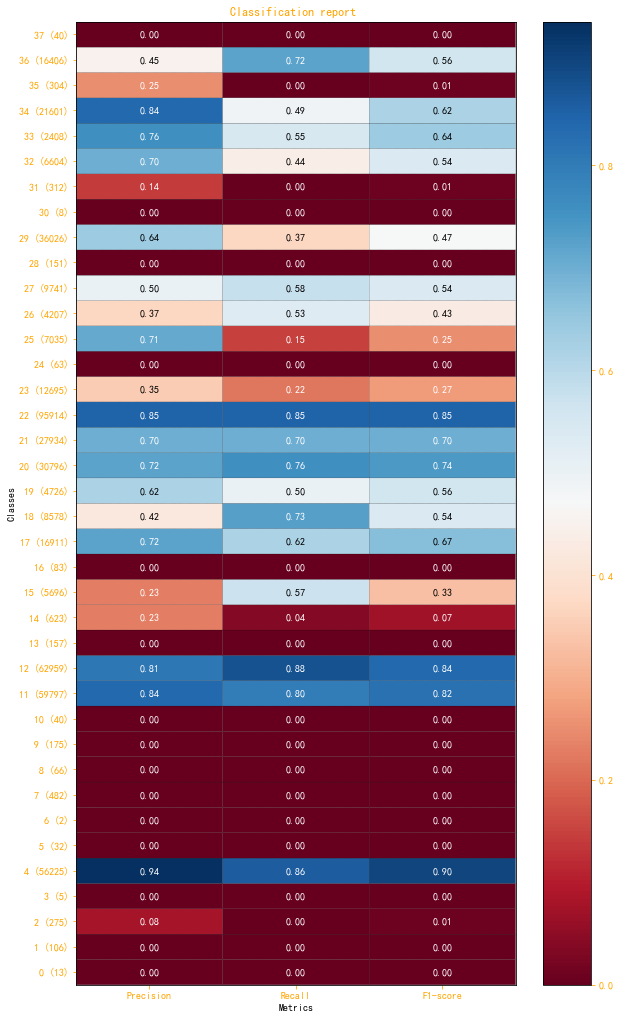

In [117]:
# TF-IDF
from sklearn.metrics import classification_report
plot_classification_report(classification_report(y_test, clf_2.predict(x_test)))

**使用部分数据集时（200000时）**：可以发现，单纯词频构建的模型在召回率(Recall)上得分很高，但准确率(Precision)很低，而TF-IDF的二者相对均衡，但更侧重于准确率。另外还测试了停词(stop_words)对TF-IDF结果的影响，发现好像没什么影响(?)可能说明引入IDF确实能够较好的消除停词这类词带来的影响。

**使用全部数据集时**：发现这两种词袋对占比大的类别都有较好的分类效果，但总体而言，TF-IDF性能更优

**另外还注意到**：在使用朴素贝叶斯和多分类结合的模型进行分类时，消耗的时间好像并不受到数据数量大小的影响?在我的环境下都是18.8s(唯一例外是TF-IDF跑全部数据集时花了27s)。具体原因尚不明，先在此记录，稍后考证。

（有时间再尝试使用其他分类器，看看别的分类器的分类效果）

### 思路2
使用深度学习模型，单词进行词嵌入然后训练

#### 将数据集处理进行编码，并进行截断

In [22]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data['text'].iloc[:100000], data_label[:100000], test_size = 0.95, random_state = 1)

In [23]:
# parameter
max_features= 500
max_len= 150
embed_size=100
batch_size = 128
epochs = 5

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokens = Tokenizer(num_words = max_features)
tokens.fit_on_texts(list(data['text'].iloc[:100000]))

y_train = data_label[:100000]
x_sub_train = tokens.texts_to_sequences(data['text'].iloc[:100000])
x_sub_train = sequence.pad_sequences(x_sub_train, maxlen=max_len)

#### 定义模型并完成训练

In [9]:
# LSTM model
# Keras Layers:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D# Keras Callback Functions:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.models import Model
from keras.optimizers import Adam

sequence_input = Input(shape=(max_len, ))
x = Embedding(max_features, embed_size, trainable=True)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(19, activation="sigmoid")(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
model.fit(x_sub_train, y_train, 
          batch_size=batch_size, 
          validation_split=0.2,
          epochs=epochs)

Epoch 1/5
625/625 [==============================] - 890s 1s/step - loss: 0.2212 - accuracy: 0.3791 - val_loss: 0.1155 - val_accuracy: 0.6654
Epoch 2/5
625/625 [==============================] - 938s 2s/step - loss: 0.1144 - accuracy: 0.6703 - val_loss: 0.1042 - val_accuracy: 0.6959
Epoch 3/5
625/625 [==============================] - 943s 2s/step - loss: 0.1045 - accuracy: 0.6978 - val_loss: 0.1001 - val_accuracy: 0.7050
Epoch 4/5
625/625 [==============================] - 952s 2s/step - loss: 0.1003 - accuracy: 0.7033 - val_loss: 0.0975 - val_accuracy: 0.7096
Epoch 5/5
625/625 [==============================] - 951s 2s/step - loss: 0.0973 - accuracy: 0.7118 - val_loss: 0.0950 - val_accuracy: 0.7196


In [16]:
# 保存模型
mp = "./keras/LSTM"
model.save(mp)

INFO:tensorflow:Assets written to: ./keras/LSTM\assets


In [17]:
from keras.models import load_model
model = load_model('./keras/LSTM')

In [28]:
loss_and_metrics = model.evaluate(x_sub_train, y_train, batch_size=128)

782/782 [==============================] - 248s 317ms/step - loss: 0.0927 - accuracy: 0.7231


In [31]:
classes = model.predict(x_sub_train, batch_size=128)